In [94]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,InputLayer,BatchNormalization,Input
from keras.models import Sequential, load_model,Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.callbacks import Callback
import sklearn
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
from keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TrueNegatives,TruePositives,Precision,Recall,AUC


In [ ]:
dataset,dataset_info = tfds.load('malaria',with_info = True , as_supervised = True,shuffle_files = True,split = ['train'])

In [ ]:
for data in dataset[0].take(4):
  print(data)

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
dataset_info.features['label'].int2str(0)

In [ ]:
IM_SIZE = 224

def resizing(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label


In [ ]:
train_dataset = train_dataset.map(resizing)
val_dataset = val_dataset.map(resizing)
test_dataset = test_dataset.map(resizing)

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

In [ ]:
for image,label in val_dataset.take(1):
  print(image,label)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8,reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

<h2>Using Sequential API</h2>

In [ ]:
from keras.layers import InputLayer
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

    Conv2D(filters = 6,kernel_size = 3,strides = 1,padding = 'valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides = 2),

    Conv2D(filters = 16,kernel_size = 3,strides = 1,padding = 'valid' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2,strides = 2),

    Flatten(),

    Dense(100,activation = "relu"),
    BatchNormalization(),

    Dense(10,activation = "relu"),
    BatchNormalization(),

    Dense(1,activation = "sigmoid")
])
lenet_model.summary()


##Functional API

<h2>Using Funcitonal API</h2>

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),

                             Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D (pool_size = 2, strides= 2),



])
feature_extractor_seq_model.summary()

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

<h3>Callbacks</h2>

In [ ]:
metrics = [TruePositives(name = 'tp'),FalsePositives(name = 'fp'),TrueNegatives(name = 'tn'),FalseNegatives(name = 'fn'),BinaryAccuracy(name = 'accuracy'),Precision(name = 'precision'),Recall(name = 'recall'),AUC(name = 'auc')]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.1),
              loss = BinaryCrossentropy(),metrics = metrics)

In [ ]:
train_dataset

In [ ]:
val_dataset

In [ ]:
history = lenet_model.fit(train_dataset,validation_data = val_dataset , epochs = 5, verbose =1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train_loss' , 'val_loss')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()


In [ ]:
test_dataset = test_dataset.batch(1)


In [ ]:
test_dataset

In [69]:
lenet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.9096 - auc: 0.9614 - fn: 15.2875 - fp: 104.3158 - loss: 0.3113 - precision: 0.8596 - recall: 0.9769 - tn: 587.5337 - tp: 672.3626


[0.29969778656959534,
 0.9125861525535583,
 0.9616735577583313,
 30.0,
 211.0,
 0.8630759119987488,
 0.9779411554336548,
 1186.0,
 1330.0]

<h3>Confusion Matrix</h3>

In [56]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [58]:
labels = np.array([i[0] for i in labels])
print(labels)

[1 1 1 ... 1 0 1]


In [60]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [61]:
predicted = lenet_model.predict(np.array(inp)[:,0,...])

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step


In [65]:
print(predicted[:,0])

[0.98216987 0.98076385 0.98544294 ... 0.9846944  0.949571   0.99503607]


In [ ]:
lenet_model.predict(test_dataset.take(1))[0][0]

[[1242  149]
 [  40 1326]]


Text(0.5, 58.7222222222222, 'Predicted')

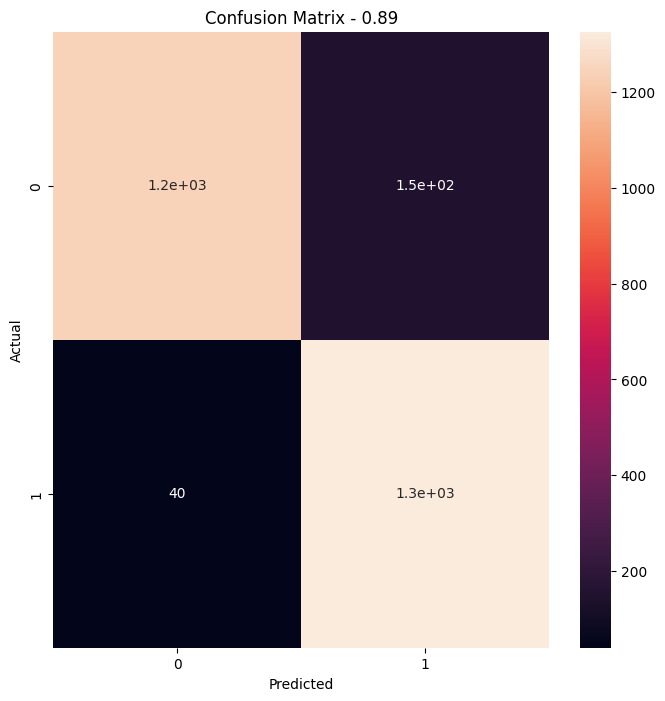

In [93]:
threshold = 0.89

cm = confusion_matrix(labels,predicted > threshold)
print(cm)
plt.figure(figsize = (8,8))

sns.heatmap(cm,annot=True,)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

<h3>ROC Plots</h3>

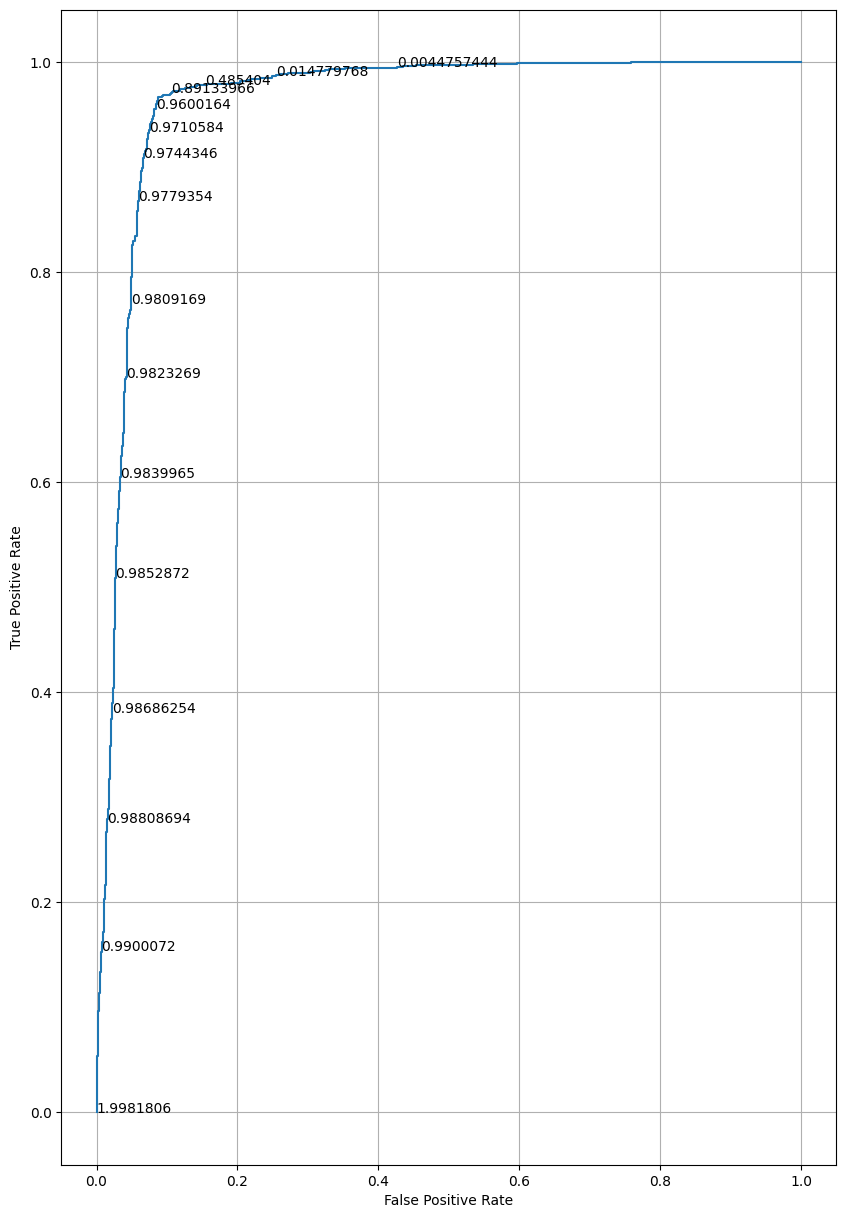

In [81]:
# Parasite -> 1, Uninfected -> 0, thus trying to minimize false positives
fp,tp,thresholds = roc_curve(labels,predicted) 
plt.figure(figsize=(10,15))
plt.plot(fp,tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
skip = 20
for i in range(0,len(thresholds),skip):
    plt.text(fp[i],tp[i],thresholds[i])
plt.show()

In [ ]:
def parasite_or_not(x):
  if x > 0.5:
    return str('P')
  else:
    return str('U')

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')